Loading the fake news dataset...

In [2]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git

#All these packages need to be installed from pip
#For ML
import sklearn
import sklearn.naive_bayes
import sklearn.tree
import sklearn.ensemble
import sklearn.neural_network
import sklearn.decomposition

import nltk #For tokenizing and normalizing
import numpy as np #arrays
import matplotlib.pyplot as plt #Plots
import matplotlib.colors # For nice colours
import seaborn #Makes plots look nice, also heatmaps
import scipy as sp #for interp

#These are from the standard library
import collections
import os
import os.path
import random
import re
import glob
import pandas
import requests
import json
import math

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

You have to download all the nltk documents
[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to ../data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to ../data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to ../data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to ../data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to ../data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to ../data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.
[nltk_data]    | Downloading package cess_esp to ../data...
[nltk_data]    |   Unzipping corpora/cess_esp.zip.
[nltk_data]    | Downloading package chat80 to ../data...
[nltk_data]    |   Unzipping corpora/chat80.zip.
[nltk_data]    | 

[nltk_data]    |   Unzipping corpora/verbnet.zip.
[nltk_data]    | Downloading package webtext to ../data...
[nltk_data]    |   Unzipping corpora/webtext.zip.
[nltk_data]    | Downloading package wordnet to ../data...
[nltk_data]    |   Unzipping corpora/wordnet.zip.
[nltk_data]    | Downloading package wordnet_ic to ../data...
[nltk_data]    |   Unzipping corpora/wordnet_ic.zip.
[nltk_data]    | Downloading package words to ../data...
[nltk_data]    |   Unzipping corpora/words.zip.
[nltk_data]    | Downloading package ycoe to ../data...
[nltk_data]    |   Unzipping corpora/ycoe.zip.
[nltk_data]    | Downloading package rslp to ../data...
[nltk_data]    |   Unzipping stemmers/rslp.zip.
[nltk_data]    | Downloading package maxent_treebank_pos_tagger to
[nltk_data]    |     ../data...
[nltk_data]    |   Unzipping taggers/maxent_treebank_pos_tagger.zip.
[nltk_data]    | Downloading package universal_tagset to ../data...
[nltk_data]    |   Unzipping taggers/universal_tagset.zip.
[nltk_data

In [5]:
## Loading the data
print("Loading Fake news data")
fakeDf = pandas.read_csv("../DATA/fake.csv")
fakeDf['category'] = fakeDf['type']
fakeDf = fakeDf.dropna()

Loading Fake news data


In [12]:
holdBackFraction = .2
print("Converting to vectors")
vecs_generated = lucem_illud.generateVecs(fakeDf)
dfTrain, dfTest = lucem_illud.trainTestSplit(vecs_generated)

Converting to vectors


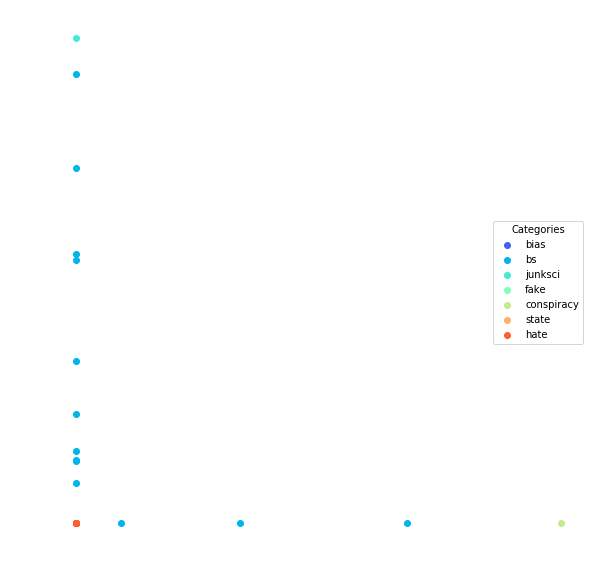

In [13]:
lucem_illud.plotter(dfTrain)

Now we import our Decision Tree classifier from sklearn.tree (familiar syntax) and fit it using the fit method.

In [14]:
clf_tree = sklearn.tree.DecisionTreeClassifier(max_depth=4,random_state=0)
clf_tree.fit(np.stack(dfTrain['vect'], axis =0), dfTrain['category'])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

To see what's going on visually with the classification: 

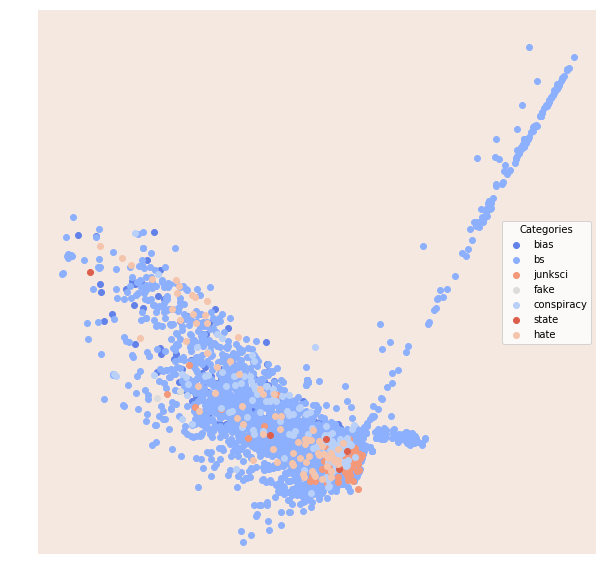

In [19]:
lucem_illud.plotregions(clf_tree, dfTrain)

In [20]:
lucem_illud.evaluateClassifier(clf_tree, dfTest)

/Users/arvindilamaran/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
bias,0.692884,0.403958,0.045745,0.928571,0.388060
bs,0.648750,0.890526,0.106383,0.890625,0.997500
junksci,0.722222,0.455083,0.010638,1.000000,0.444444
conspiracy,0.648148,0.316509,0.020213,1.000000,0.296296
state,0.500000,0.001064,0.001064,0.000000,0.000000
hate,0.500000,0.028723,0.028723,0.000000,0.000000


Lets look at accuracy:

In [21]:
sklearn.metrics.accuracy_score(dfTest['category'],clf_tree.predict(np.stack(dfTest['vect'], axis = 0)))

0.8936170212765957

What happens if we trim the tree?

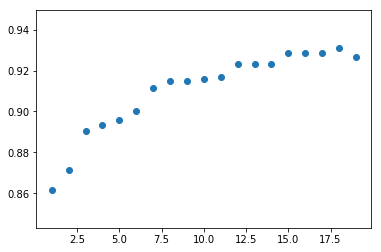

In [22]:
depthvec = []
scorevec = []
for i in range(1,20):
    tree2 = sklearn.tree.DecisionTreeClassifier(max_depth=i,random_state=0)
    tree2.fit(np.stack(dfTrain['vect'], axis =0), dfTrain['category'])
    score = sklearn.metrics.accuracy_score(dfTest['category'], tree2.predict(np.stack(dfTest['vect'], axis = 0)))
    depthvec.append(i)
    scorevec.append(score)
plt.scatter(depthvec,scorevec)
plt.show()

We can select different layers of the decision tree or "prune" it. At approximately four layers down in the decision tree, the shape is somewhat odd, suggesting that our model is overfitting beyond those four layers.

Combining multiple overfitting estimators turns out to be a key idea in machine learning. This is called **bagging** and is a type of **ensemble** method. The idea is to make many randomized estimators--each can overfit, as decision trees are wont to do--but then to combine them, ultimately producing a better classification. A **random forest** is produced by bagging decision trees.

In [23]:
tree = sklearn.tree.DecisionTreeClassifier(max_depth=10) #Create an instance of our decision tree classifier.

bag = sklearn.ensemble.BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1) #Each tree uses up to 80% of the data

In [24]:
bag.fit(np.stack(dfTrain['vect'], axis =0), dfTrain['category']) #Fit the bagged classifier

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=0.8, n_estimators=100, n_jobs=1, oob_score=False,
         random_state=1, verbose=0, warm_start=False)

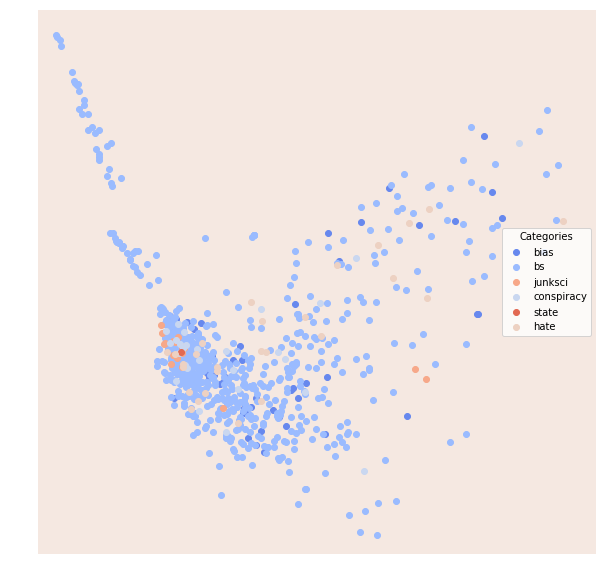

In [25]:
lucem_illud.plotregions(bag, dfTest)

In [26]:
lucem_illud.evaluateClassifier(bag, dfTest)

/Users/arvindilamaran/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
bias,0.707810,0.431539,0.043617,0.933333,0.417910
bs,0.716607,0.909773,0.086170,0.909920,0.997500
junksci,0.861111,0.727541,0.005319,1.000000,0.722222
conspiracy,0.648148,0.316509,0.020213,1.000000,0.296296
state,0.500000,0.001064,0.001064,0.000000,0.000000
hate,0.722222,0.460402,0.015957,1.000000,0.444444


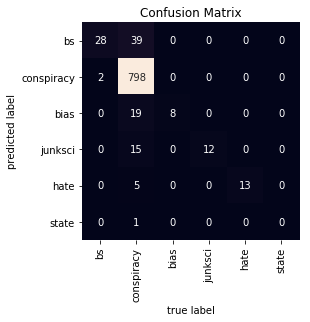

In [27]:
lucem_illud.plotConfusionMatrix(bag, dfTest)

# K-Nearest Neighbors

The K-Nearest neighbors classifier takes a simpler premise than those before: Find the closest labeled datapoint in set and "borrow" its label.

Let's use newsgroup data again.

Make a testing and training set:

In [6]:
holdBackFraction = .2
train_ng_df, test_ng_df = lucem_illud.trainTestSplit(fakeDf, holdBackFraction=holdBackFraction)

Let's initialize our k-nearest neighbors classifier:

In [7]:
n_neighbors = 15
weights="uniform"
clf_knearest = sklearn.neighbors.KNeighborsClassifier(n_neighbors, weights=weights)

Let's try to classify using the TF-IDF vectors:

In [8]:
TFVectorizer_ng = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects_ng = TFVectorizer_ng.fit_transform(train_ng_df['text'])
train_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_ng.todense()]

In [9]:
clf_knearest.fit(np.stack(train_ng_df['vect'], axis = 0), train_ng_df['category'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=15, p=2,
           weights='uniform')

In [10]:
lucem_illud.evaluateClassifier(clf_knearest, train_ng_df)

/Users/arvindilamaran/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
junksci,0.520270,0.059413,0.018873,1.000000,0.040541
state,0.500000,0.001595,0.001595,0.000000,0.000000
bias,0.557181,0.153900,0.051834,0.892857,0.115207
bs,0.557831,0.876748,0.121744,0.876757,0.999384
conspiracy,0.609351,0.240357,0.028708,0.967742,0.218978
hate,0.500000,0.021265,0.021265,0.000000,0.000000
fake,0.500000,0.000532,0.000532,0.000000,0.000000


And lets look at the testing data

In [11]:
#Create vectors
TFVects_test = TFVectorizer_ng.transform(test_ng_df['text'])
test_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#Add to df
test_ng_df['nb_predict'] = clf_knearest.predict(np.stack(test_ng_df['vect'], axis=0))

#Test
print("Testing score:")
print(clf_knearest.score(np.stack(test_ng_df['vect'], axis=0), test_ng_df['category']))

Testing score:
0.8765957446808511


Let's produce another confusion matrix:

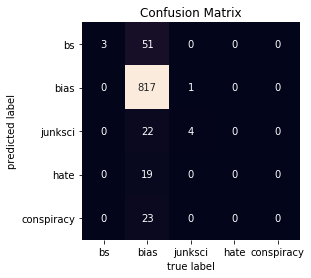

In [12]:
lucem_illud.plotConfusionMatrix(clf_knearest, test_ng_df)

You can produce the PCA space visual if you want, altough it can take a very long time, so we'll leave it optionally commented out:

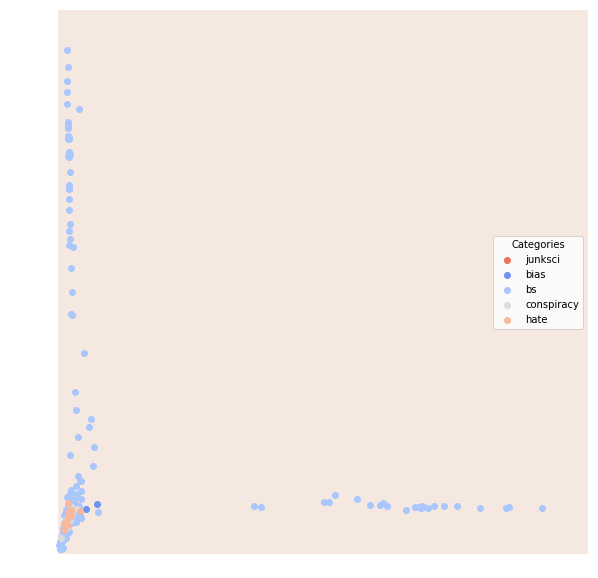

In [13]:
lucem_illud.plotregions(clf_knearest, test_ng_df)

# SVMs

Now we will examine Support Vector Machines, an approach that creates the partition that preserves the "maximum margin" between classes.

We will use the same fake news data

In [28]:
#tokenize and normalize
fakeDf['tokenized_text'] = fakeDf['text'].apply(lambda x: nltk.word_tokenize(x))
fakeDf['normalized_text'] = fakeDf['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x, stopwordLst = lucem_illud.stop_words_basic, stemmer = lucem_illud.stemmer_basic))

We will tf.idf the data to make our vectors:

In [29]:
fakeTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, min_df=3, stop_words='english', norm='l2')
fakeTFVects = fakeTFVectorizer.fit_transform([' '.join(l) for l in fakeDf['normalized_text']])
fakeDf['vect'] = [np.array(v).flatten() for v in fakeTFVects.todense()]

Initilize the model and make a train test split:

In [30]:
holdBackFraction = .2
train_redditDf, test_redditDf = lucem_illud.trainTestSplit(fakeDf, holdBackFraction=holdBackFraction)

In [31]:
clf_svm = sklearn.svm.SVC(kernel='linear', probability = False)
#probability = True is slower but  lets you call predict_proba()
clf_svm.fit(np.stack(train_redditDf['vect'], axis=0), train_redditDf['category'])

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

...and consider the results:

In [32]:
lucem_illud.evaluateClassifier(clf_svm, test_redditDf)

/Users/arvindilamaran/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
bias,0.616667,0.282270,0.048936,1.000000,0.233333
bs,0.575758,0.878261,0.119149,0.878261,1.000000
junksci,0.500000,0.022340,0.022340,0.000000,0.000000
fake,0.500000,0.001064,0.001064,0.000000,0.000000
conspiracy,0.567568,0.169178,0.034043,1.000000,0.135135
state,0.500000,0.002128,0.002128,0.000000,0.000000
hate,0.545455,0.101547,0.010638,1.000000,0.090909


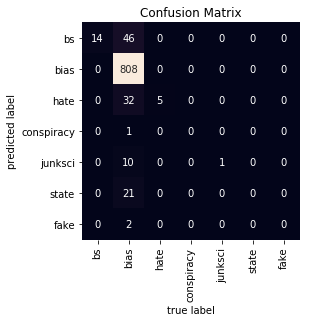

In [33]:
lucem_illud.plotConfusionMatrix(clf_svm, test_redditDf)

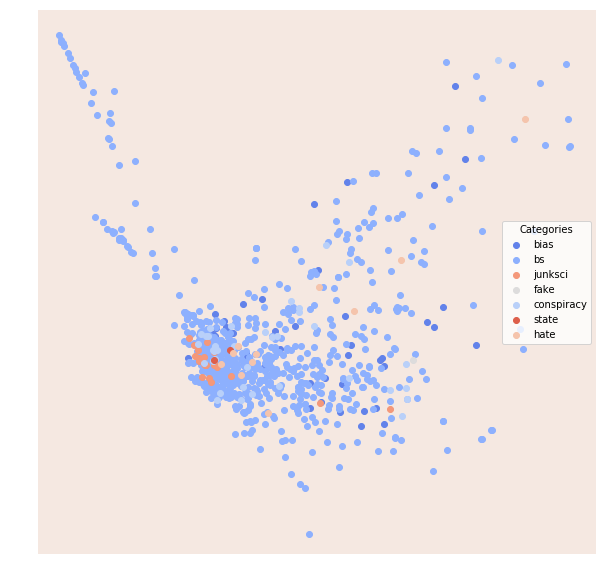

In [34]:
lucem_illud.plotregions(clf_svm, test_redditDf)

# Neural Nets

We include an example of a simple neural network, the Multi-layer Perceptron (MLP) that learns a function $f(\cdot): R^m \rightarrow R^o$ by training on a dataset, where $m$ is the number of dimensions for input and $o$ is the number of dimensions for output. Given a set of features $X = {x_1, x_2, ..., x_m}$ and a target $y$, it can learn a non-linear function approximator for either classification or regression. It is different from logistic regression, in that between the input and the output layer, there can be one or more non-linear layers, called hidden layers. The following figure shows a one hidden layer MLP with scalar output. ![title](../data/multilayerperceptron_network.png) The leftmost layer, known as the input layer, consists of a set of "neurons" $\{x_i | x_1, x_2, ..., x_m\}$ representing the input features (e.g., weighted words). Each neuron in the hidden layer transforms the values from the previous layer with a weighted linear summation $w_1x_1 + w_2x_2 + ... + w_mx_m$, followed by a non-linear activation function $g(\cdot):R \rightarrow R$ - like the logistic or hyperbolic tan function. The output layer receives the values from the last hidden layer and transforms them into output values.

In [35]:
clf_nn = sklearn.neural_network.MLPClassifier()
clf_nn.fit(np.stack(train_redditDf['vect'], axis=0), train_redditDf['category'])

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [36]:
lucem_illud.evaluateClassifier(clf_nn, test_redditDf)

/Users/arvindilamaran/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
bias,0.714394,0.411726,0.040426,0.866667,0.433333
bs,0.647183,0.896652,0.105319,0.896976,0.991337
junksci,0.570340,0.104863,0.021277,0.600000,0.142857
fake,0.500000,0.001064,0.001064,0.000000,0.000000
conspiracy,0.607001,0.203824,0.032979,0.800000,0.216216
state,0.500000,0.002128,0.002128,0.000000,0.000000
hate,0.544916,0.056093,0.011702,0.500000,0.090909


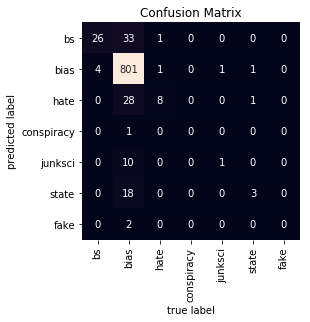

In [37]:
lucem_illud.plotConfusionMatrix(clf_nn, test_redditDf)

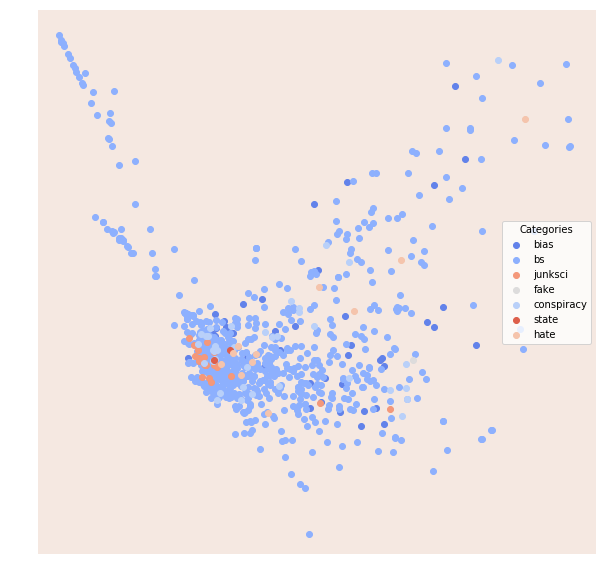

In [38]:
lucem_illud.plotregions(clf_nn, test_redditDf)